In [47]:
#Importing modules
import Quandl
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import seaborn as sns
sns.set(color_codes=True, font_scale = 1.5, style = 'darkgrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn import svm, preprocessing, cross_validation, grid_search, linear_model, naive_bayes, metrics

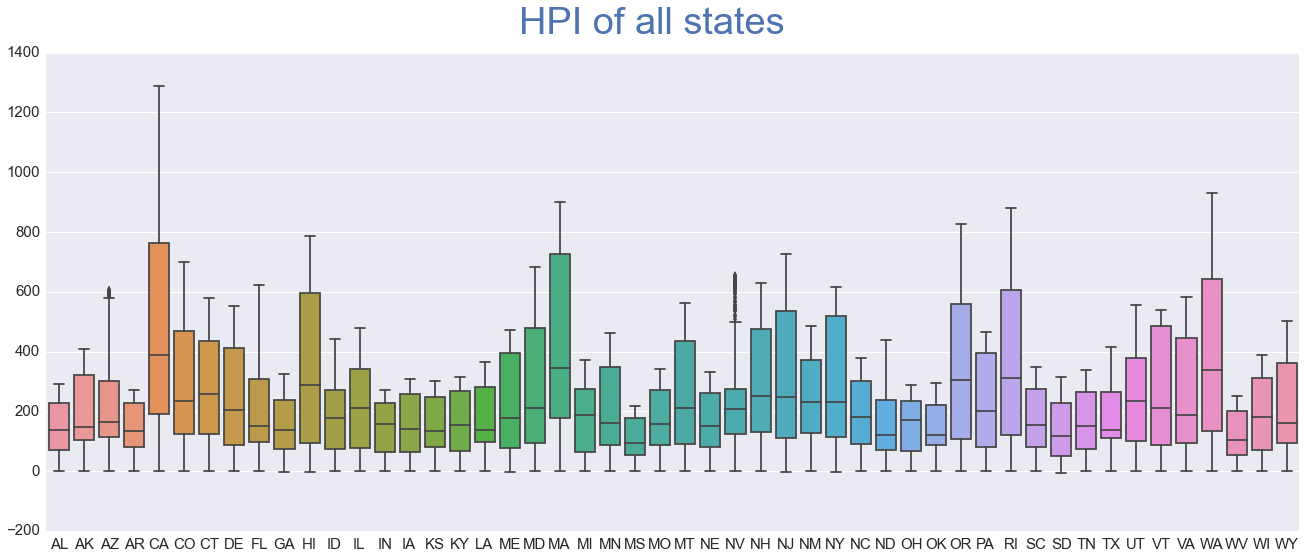

In [2]:
#Using my authorization token for Quandl
auth_token = open("auth_key.txt",'r').read()

#Creating a List of abbreviation of each state
# def list_states():
#     df = pd.read_html("http://www.50states.com/abbreviations.htm#.VnM8VfkrLIU")
#     df_states = pd.DataFrame(df[0])
#     df_states = df_states.iloc[1:51][1]
#     #list_states = df_states["Abbreviation"]
#     list_states = np.array(df_states)
#     return list_states

# #Getting house prices of all states from Quandl by modifying its get function
# def house_price_all_states():
#     main_df = pd.DataFrame()
#     states = list_states()
#     for abbv in states:
#         df = Quandl.get("FMAC/HPI_"+str(abbv), authtoken = auth_token)
#         df[abbv] = ((df[abbv]-df[abbv][0])/df[abbv][0]) * 100
#         if main_df.empty:
#             main_df = df
#         else:
#             main_df = main_df.join(df)
#     main_df.to_pickle("fiddy_state.pickle") #Pickling the data to reduce run time
# house_price_all_states()

HPI_All_States = pd.read_pickle("fiddy_state.pickle")

#Plotting Boxplot of percent change of each state
plt.figure(figsize=(20,8))
sns.boxplot(data=HPI_All_States)
plt.suptitle("HPI of all states", x=0.5,y=0.98, color = 'b', size = 38)
plt.show()

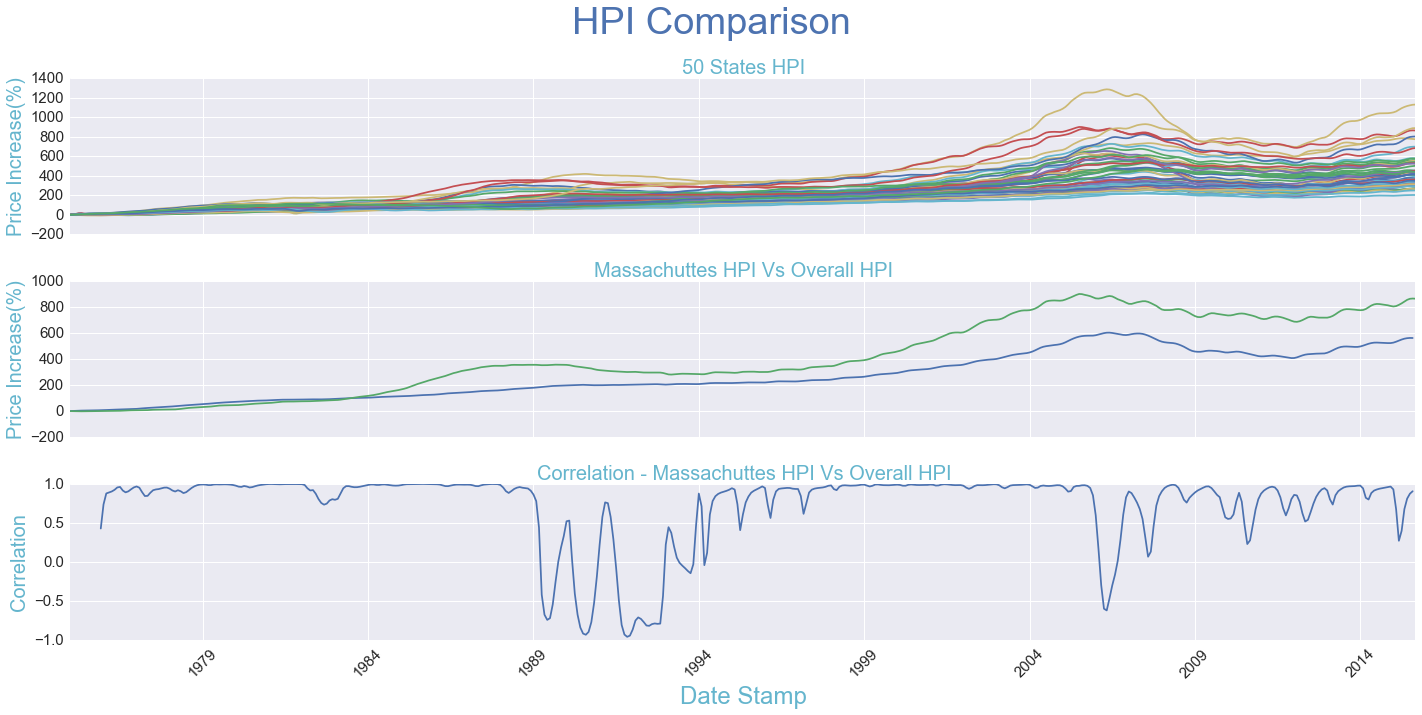

In [3]:
#Gathering US house price data
def benchmark():
    df = Quandl.get("FMAC/HPI_USA", authtoken = auth_token)
    df.columns = ["US_HPI"]
    #Scaling data points
    df["US_HPI"] = ((df["US_HPI"]-df["US_HPI"][0])/df["US_HPI"][0]) * 100
    return df

HPI_US = benchmark()
HPI_US["US_HPI_Future"] = HPI_US["US_HPI"].shift(-1)
HPI_US.dropna(inplace = True)
fig = plt.figure()
plt.figure(figsize=(20,10))

#Plotting all states HPI and correlation between MA and US HPI
plt.suptitle("HPI Comparison", x=0.5,y=0.98, color = 'b', size = 38)
ax1 =  plt.subplot2grid((3,1),(0,0))
HPI_All_States.plot(legend = False, fig = fig, ax = ax1)
ax1.set_title('50 States HPI', color = 'c', size = 20)
ax1.set_ylabel("Price Increase(%)", color = 'c', size = 20)

ax2 = plt.subplot2grid((3,1),(1,0), sharex = ax1)
HPI_US["US_HPI_Future"].plot(ax = ax2, label = 'Future HPI' )
HPI_All_States['MA'].plot(ax = ax2, label = 'MA HPI')
ax2.set_title('Massachuttes HPI Vs Overall HPI', color = 'c', size = 20)
ax2.set_ylabel("Price Increase(%)", color = 'c', size = 20)

ax3 = plt.subplot2grid((3,1),(2,0), sharex = ax1)
HPI_corr = pd.rolling_corr(HPI_All_States['MA'], HPI_US["US_HPI_Future"], 12)
HPI_corr.plot(ax = ax3, label = 'Correlation')
ax3.set_title('Correlation - Massachuttes HPI Vs Overall HPI', color = 'c', size = 20)
for label in ax3.xaxis.get_ticklabels():
        label.set_rotation(45)
ax3.set_xlabel("Date Stamp", color = 'c', size = 24)
ax3.set_ylabel("Correlation", color = 'c', size = 20)

plt.subplots_adjust(left=0.056, bottom=0.10, right=0.99, top=0.88, wspace=0.0, hspace=0.3)      
plt.show()

              AL         AK         AZ         AR         CA         CO  \
count  52.000000  52.000000  52.000000  52.000000  52.000000  52.000000   
mean    0.969750   0.936543   0.930286   0.971007   0.944899   0.957396   
std     0.027255   0.044276   0.030142   0.027912   0.028140   0.029905   
min     0.864963   0.758296   0.836533   0.852639   0.865150   0.833116   
25%     0.956560   0.928066   0.915171   0.966409   0.930089   0.944313   
50%     0.977251   0.945549   0.931981   0.979260   0.945350   0.963864   
75%     0.986670   0.960859   0.947713   0.988598   0.966184   0.976420   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

              CT         DE         FL         GA      ...               TX  \
count  52.000000  52.000000  52.000000  52.000000      ...        52.000000   
mean    0.936883   0.964843   0.926705   0.950899      ...         0.938300   
std     0.037310   0.028847   0.034767   0.029939      ...         0.040739   
min     

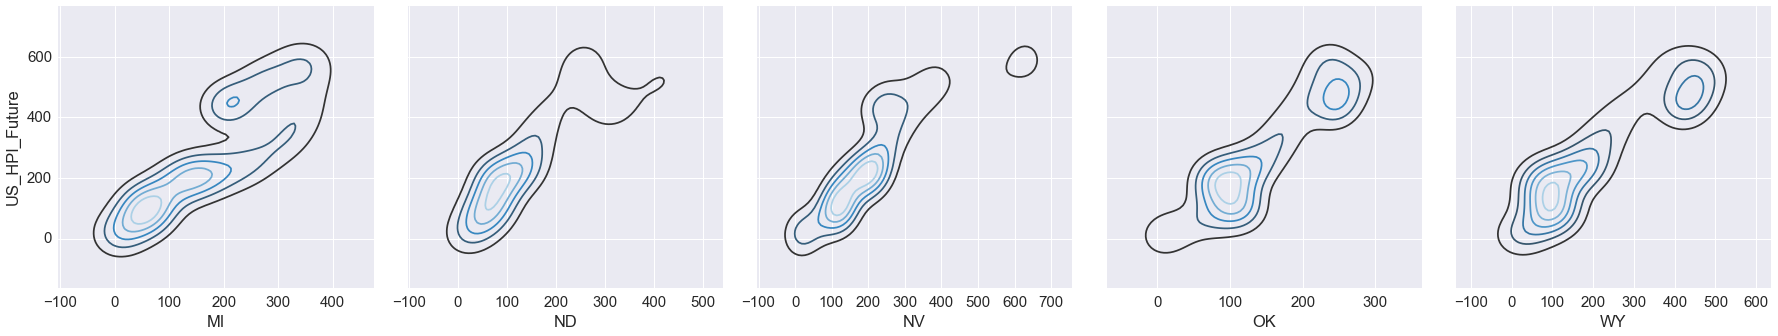

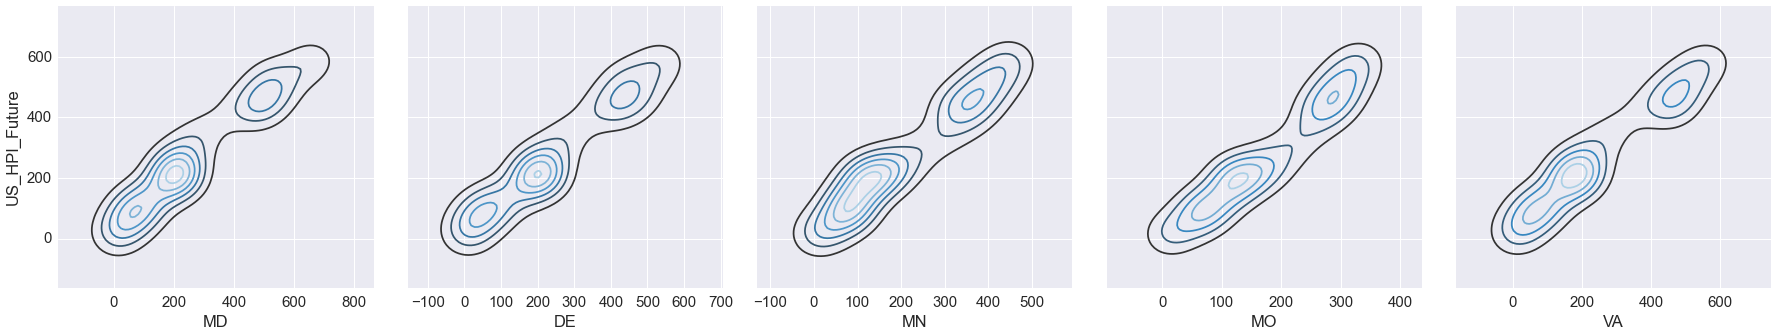

In [4]:
HPI_combined = HPI_All_States.join(HPI_US[['US_HPI', "US_HPI_Future"]])
HPI_combined.dropna(inplace = True)

HPI_corr = HPI_combined.corr()
print(HPI_corr.describe())
HPI_corr = HPI_corr.iloc[0:50]
HPI_corr.sort(columns = 'US_HPI_Future', inplace = True)
Least_corr_states = HPI_corr.head(5)
Least_corr_states = list(Least_corr_states.index.values)
Highest_corr_states = HPI_corr.tail(5)
Highest_corr_states = list(Highest_corr_states.index.values)

for num in range(np.int(len(Least_corr_states)/5)):
    g = sns.PairGrid(HPI_combined, x_vars= Least_corr_states[num:num+5], y_vars=["US_HPI_Future"], palette="Set2", size = 5)
    g.map(sns.kdeplot, cmap="Blues_d", n_levels=6)
for num in range(np.int(len(Highest_corr_states)/5)):
    g = sns.PairGrid(HPI_combined, x_vars= Highest_corr_states[num:num+5], y_vars=["US_HPI_Future"], palette="Set2", size = 5)
    g.map(sns.kdeplot, cmap="Blues_d", n_levels=6)
plt.show()

                 US_gdp  US_HPI_Future
US_gdp         1.000000       0.587365
US_HPI_Future  0.587365       1.000000


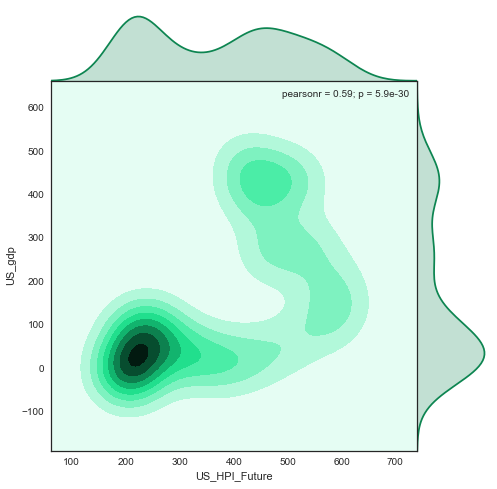

In [5]:
#Getting US GPD data
def gdp():
    df = Quandl.get("BCB/4385", authtoken=auth_token, trim_start="1974-12-31")
    df.columns = ["US_gdp"]
    #Scaling data points
    df["US_gdp"] = ((df["US_gdp"]-df["US_gdp"][0])/df["US_gdp"][0]) * 100
    return df

US_GDP = gdp()
HPI_combined = HPI_combined.join(US_GDP["US_gdp"])
HPI_combined.dropna(inplace = True)

print(HPI_combined[["US_gdp","US_HPI_Future"]].corr())

sns.set(style="white")
sns.jointplot(x=HPI_combined["US_HPI_Future"], y=HPI_combined["US_gdp"], kind = 'kde', color="#0d8551", space = 0, size = 7)

               Mortage_Rates  US_HPI_Future
Mortage_Rates       1.000000      -0.747675
US_HPI_Future      -0.747675       1.000000


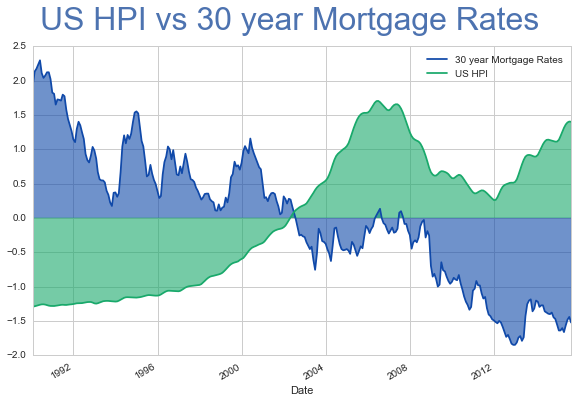

In [6]:
#Getting US Mortgage rates data
def mortgage_30():
    df = Quandl.get("FMAC/MORTG", authtoken = auth_token, trim_start = "1975-01-01")
    df.columns = ["Mortage_Rates"]
    #Scaling and adjusting data points
    df["Mortage_Rates"] = ((df["Mortage_Rates"]-df["Mortage_Rates"][0])/df["Mortage_Rates"][0]) * 100
    df = df.resample('D')
    df = df.resample('M')
    return df

#Combining and checking correlation 
Mortage_Rates = mortgage_30()
HPI_combined = HPI_combined.join(Mortage_Rates)
HPI_combined.dropna(inplace = True)
print(HPI_combined[["Mortage_Rates","US_HPI_Future"]].corr())

#Normalizing to faciliate plotting in same axes
HPI_combined_norm = (HPI_combined - HPI_combined.mean())/HPI_combined.std()

#Plotting US HPI vs 30 year Mortgage Rates
sns.set(style='whitegrid')
ax1 =  plt.subplot2grid((1,1),(0,0))
plt.suptitle("US HPI vs 30 year Mortgage Rates", x=0.5,y=0.98, color = 'b', size = 32)

ax1.plot(HPI_combined_norm.index, HPI_combined_norm.Mortage_Rates, label = '30 year Mortgage Rates',color = '#1049a9')
HPI_combined_norm['US_HPI_Future'].plot(ax = ax1, label = 'US HPI', color = '#19a96b')
#Adding a fill
ax1.fill_between(HPI_combined_norm.index, HPI_combined_norm.Mortage_Rates, alpha = 0.6, color = '#1049a9')
ax1.fill_between(HPI_combined_norm.index, HPI_combined_norm['US_HPI_Future'], alpha = 0.6, color = '#19a96b')

plt.subplots_adjust(left=0.056, bottom=0.10, right=0.99, top=0.88, wspace=0.0, hspace=0.0)      
plt.legend()
plt.show()

               Unemployment  US_HPI_Future
Unemployment       1.000000       0.022649
US_HPI_Future      0.022649       1.000000


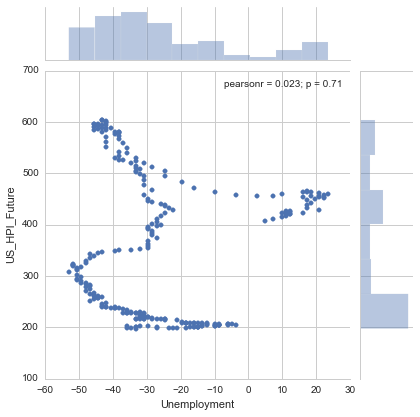

In [7]:
#Getting US Unemployment data
def unemployment():
    df = Quandl.get("ECPI/JOB_G", authtoken = auth_token, trim_start = "1975-01-01")
    df.columns = ["Unemployment"]
    #Scaling and adjusting data points
    df["Unemployment"] = ((df["Unemployment"]-df["Unemployment"][0])/df["Unemployment"][0]) * 100
    df = df.resample('D')
    df = df.resample('M')
    return df

#Combining and checking correlation 
Unemployment = unemployment()
HPI_combined = HPI_combined.join(Unemployment)
HPI_combined.dropna(inplace = True)
print(HPI_combined[["Unemployment","US_HPI_Future"]].corr())

#Figuring out some pattern by plotting scatter plot of Unemployment vs US HPI 
sns.jointplot(x='Unemployment', y = 'US_HPI_Future', data = HPI_combined)
plt.show()

#Very poor correlation, not using unemployment data
HPI_combined.drop('Unemployment', 1, inplace = True)

                  SP500  US_HPI_Future
SP500          1.000000       0.736759
US_HPI_Future  0.736759       1.000000


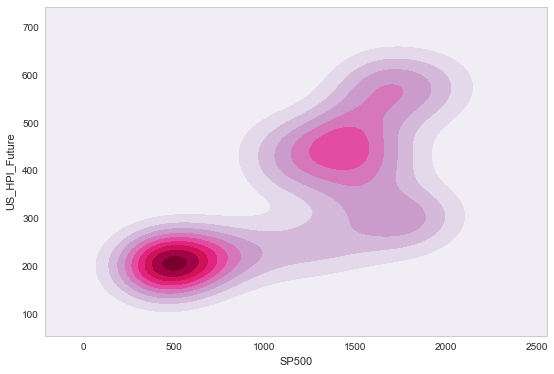

In [8]:
#S&P500
def sp500():
    df = Quandl.get("YAHOO/INDEX_GSPC", authtoken = auth_token, trim_start = "1975-01-01")
    df = pd.DataFrame(df["Close"]) #Using the close datapoints from the OHLC options
    df = df.resample('M')
    df.columns = ["SP500"]
    df["SP500"] = ((df["SP500"]-df["SP500"][0])/df["SP500"][0]) * 100
    return df

#Combining and checking correlation 
SP500 = sp500()
HPI_combined = HPI_combined.join(SP500)
HPI_combined.dropna(inplace = True)
print(HPI_combined[["SP500","US_HPI_Future"]].corr())

#Plotting density plot between US HPI and S&P500
sns.kdeplot(HPI_combined.SP500 , HPI_combined.US_HPI_Future, cmap = 'PuRd', shade = True)

HPI_combined.to_pickle('housing_market.pickle')

In [9]:
#Readying the data for classification
def label_fun(first, second):
    if second > first:
        label = 1
    else:
        label = 0
    return label

#Retrieving previously pickled data
housing_market = pd.read_pickle("housing_market.pickle")

#Changing data resolution to help classification algorithm
housing_market = housing_market.pct_change()
housing_market.replace([np.inf, -np.inf], np.nan, inplace = True)
housing_market.dropna(inplace = True)
#Labeling using increase or decrease from previous month
housing_market["label"] = list(map(label_fun, housing_market["US_HPI"],housing_market["US_HPI_Future"]))

#Creating feature dataframe and Output dataframe
X = np.array(housing_market.drop(["US_HPI_Future","label"], 1 ))
X = preprocessing.scale(X)
y = np.array(housing_market["label"])

#Dividing the data into test and training sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=0)
#Defining cross validating data set
cv = cross_validation.ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

In [16]:
#Function available in scikit-learn 0.16
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Accuracy 0.622641509434


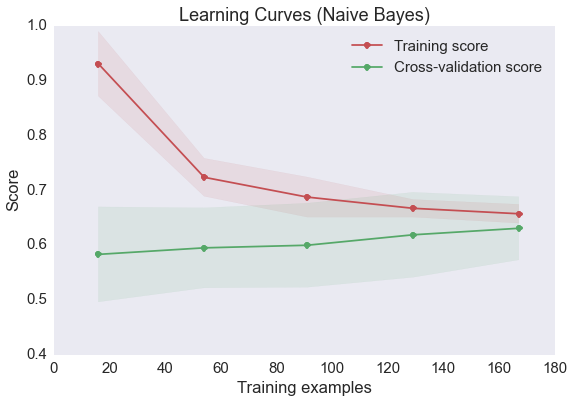

In [44]:
#Naive Bayes
title = "Learning Curves (Naive Bayes)"
naiveBayes = naive_bayes.GaussianNB()
plot_learning_curve(naiveBayes, title, X, y, cv=cv)
naiveBayes.fit(X_train, y_train)
print('Accuracy '+str(naiveBayes.score(X_test, y_test)))

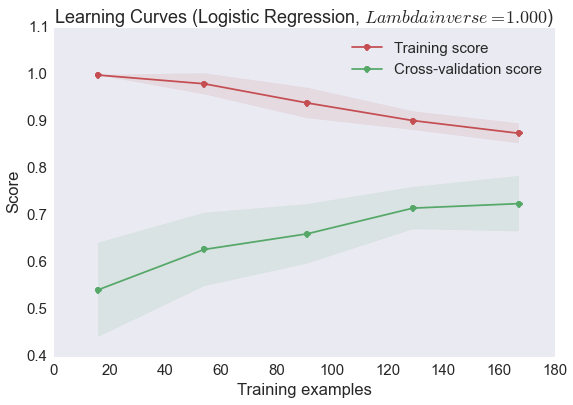

Accuracy 0.754716981132


,Features,Coefficient Estimate
0,AL,-0.121963
1,AK,-0.508579
2,AZ,-0.406660
3,AR,-0.074466
4,CA,0.339746
5,CO,1.169130
6,CT,0.048825
7,DE,-0.153757
8,FL,-0.283950
9,GA,0.745317


In [38]:
#Logistic Regression 
#Figuring out best Regulization value for Logistic Regression
logreg = linear_model.LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 0.3, 1, 3, 10, 100, 1000] }
classifier = grid_search.GridSearchCV(estimator=logreg, cv=cv, param_grid = param_grid)
classifier.fit(X_train, y_train)

#Plotting Learning Curve using the best value C
title = 'Learning Curves (Logistic Regression, $Lambdainverse=%.3f$)' %classifier.best_estimator_.C

#
logreg = linear_model.LogisticRegression(C=classifier.best_estimator_.C)
plot_learning_curve(logreg, title, X_train, y_train, cv=cv)
plt.show()
logreg.fit(X_train, y_train)

print('Accuracy '+str(logreg.score(X_test, y_test)))
#Building the coefficient/weights table
df_wghts = housing_market.drop(["US_HPI_Future","label"], 1)
df_wghts = pd.DataFrame(df_wghts.columns)
df_wghts.columns = ["Features"]
df_wghts["Coefficient Estimate"] = pd.Series(logreg.coef_[0])
df_wghts

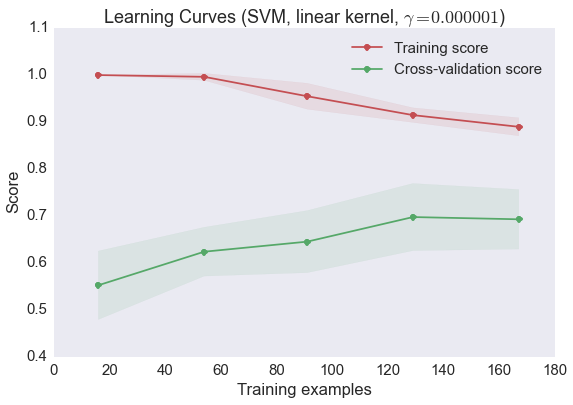

Accuracy 0.77358490566
F1 Score 0.75


,Features,Coefficient Estimate
0,AL,-0.020746
1,AK,-0.296339
2,AZ,-0.143487
3,AR,-0.113069
4,CA,0.517125
5,CO,1.039820
6,CT,0.155039
7,DE,-0.081910
8,FL,-0.371473
9,GA,0.842771


In [52]:
#SVM
#Figuring out best Gamma value for SVM
SVM = svm.SVC(kernel='linear')
gammas = np.logspace(-6, -1, 10)
classifier = grid_search.GridSearchCV(estimator=SVM, cv=cv, param_grid=dict(gamma=gammas))
classifier.fit(X_train, y_train)

title = 'Learning Curves (SVM, linear kernel, $\gamma=%.6f$)' %classifier.best_estimator_.gamma
estimator = svm.SVC(kernel='linear', gamma=classifier.best_estimator_.gamma)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv)
plt.show()
estimator.fit(X_train, y_train)

#Comparing Accuracy and F1 Score
print('Accuracy '+str(estimator.score(X_test, y_test)))
y_pred = estimator.predict(X_test)
print('F1 Score '+str(metrics.f1_score(y_test, y_pred)))
#Building the coefficient/weights table
df_wghts = housing_market.drop(["US_HPI_Future","label"], 1)
df_wghts = pd.DataFrame(df_wghts.columns)
df_wghts.columns = ["Features"]
df_wghts["Coefficient Estimate"] = pd.Series(estimator.coef_[0])
df_wghts